In [2]:
# import packages
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from sklearn import tree
from scipy.stats import norm

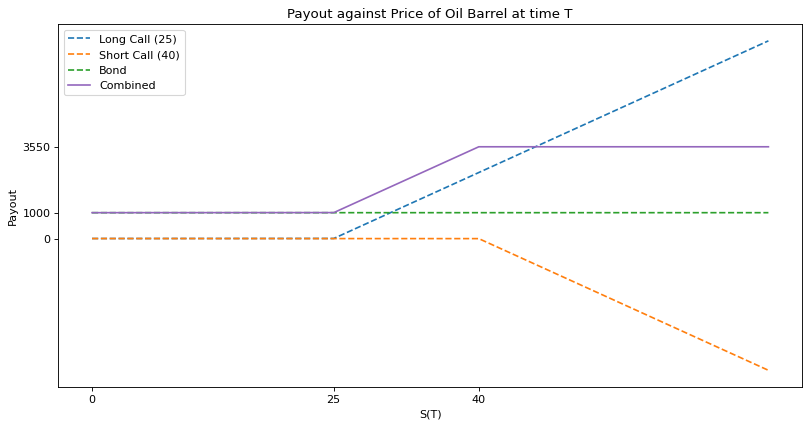

In [3]:
# 1. Show that bond issued = bond + long call (25) + short call (40)

def plot_q1(upper_lim, deg): ## upper_lim: upper limit of S(T), deg: degree accuracy of the range

    # Create range 
    st_range = np.arange(0, upper_lim, deg)

    # Payoffs for long call (25), payoff for short call (40) & bond individually
    y_long = [max(170*(x-25), 0) for x in st_range]
    y_short = [min(-170*(x-40), 0) for x in st_range]
    y_bond = [1000 for x in st_range]

    # Combing payoffs: add all 3 together 
    combined = [y_long[j] + y_short[j] + y_bond[j] for j in range(len(st_range))]

    # Plotting curves
    plots   = [y_long, y_short, y_bond]
    lbls = ['Long Call (25)', 'Short Call (40)', 'Bond']
    plt.figure(figsize=(12, 6), dpi=80)

    for i in range(len(plots)):
        plt.plot(st_range, plots[i],'--', label = lbls[i])
        
    plt.plot(st_range, combined, color = 'tab:purple', label = 'Combined')

    plt.legend(loc ='upper left')
    plt.xticks([0,25,40])
    plt.yticks([0,1000,3550])
    
    plt.title('Payout against Price of Oil Barrel at time T')
    plt.ylabel('Payout')
    plt.xlabel('S(T)')
    plt.savefig('Q1(tats) Combined Payouts.jpg')
    plt.show()


plot_q1(70, 0.01)

In [18]:
# 3 Dynamic hedging process out of the money using sample path 2
T_q3, K_q3, r_q3, sigma_q3, num_shares_q3 = 20/52, 50, 0.05, 0.2, 100000
sample_path_2 = [49, 49.75, 52, 50, 48.38, 48.25, 48.75, 49.63, 48.25, 48.25, 51.12, 51.5, 49.88, 49.88, 48.75, 47.5, 48, 46.25, 48.13, 46.63, 48.12]
sample_path_1 = [49, # In the money
                48.12,
                47.37,
                50.25,
                51.75,
                53.12,
                53,
                51.87,
                51.38,
                53,
                49.88,
                48.50,
                49.88,
                50.37,
                52.13,
                51.88,
                52.87,
                54.87,
                54.62,
                55.87,
                57.25]
# Lecture codes

def call_price(S, K, T, sigma, r): # returns fair value of call option 
    d1 = (np.log( S/K ) + (r + np.square(sigma)/2)* T )/(sigma * np.sqrt(T)) 
    d2 = d1 - sigma * np.sqrt(T)
    return norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r*T) 

def call_delta(S, K, T, sigma, r): # returns the delta value
    d1 = (np.log( S/K ) + (r + sigma * sigma / 2)* T ) / (sigma * np.sqrt(T)) 
    delta = norm.cdf(d1)
    return delta

# Creating function for question
def dynamic_hedging(sample, K, T, sigma, r, num_sh):
    column_names = ['Week', 'Stock Price', 'Delta', 'Shares Purchased', 'Cost of Shares Purchased ($000)', 'Cumulative Cash Outflow ($000)', 'Interest Cost ($000)']
    week = [i for i in range(21)]

    # Iterate weeks for each delta
    deltas = []
    for i in sample:
        deltas.append((call_delta(i, K, T, sigma, r)).round(3))
        T -= 1/52

    # Iterate for cumulative shares
    cum_shares = [(num_sh*i).round(1) for i in deltas]
    
    # Shares purchased (Current - previous)
    shares_purchased = [cum_shares[0]]+[(cum_shares[i]-cum_shares[i-1]).round(1) for i in range(1, len(cum_shares))]

    # Cost of shares purchased
    cost_of_shares = [(shares_purchased[i]*sample[i]/1000).round(1) for i in range(len(sample))]

    # Cash outflow and interest costs
    cash_outflow, interest_cost = get_cash_out_and_int(cost_of_shares, r)

    # Build output dataframe
    df_tpls = list(zip(week, sample, deltas, shares_purchased, cost_of_shares, cash_outflow, interest_cost))
    dynamic_hedge_df = pd.DataFrame(df_tpls, columns= column_names)
    dynamic_hedge_df.to_excel(excel_writer='Q3(tats) Dynamic hedging.xlsx')

    return dynamic_hedge_df

def get_cash_out_and_int(cost_of_shares, r):

    # Get base values
    cash_out, int_cost = [(cost_of_shares[0]).round(1)], [(cost_of_shares[0]*r/52).round(1)]

    # Iterate subsequent values
    for i in range(1, len(cost_of_shares)):
        cash_out.append((cost_of_shares[i] + cash_out[i-1] + int_cost[i-1]).round(2))
        int_cost.append((cash_out[i]*r/52).round(1))

    int_cost[-1] = np.nan # no more interest cost for last period

    return cash_out, int_cost
     
dynamic_hedging(sample_path_1, K_q3, T_q3, sigma_q3, r_q3, num_shares_q3)

,Week,Stock Price,Delta,Shares Purchased,Cost of Shares Purchased ($000),Cumulative Cash Outflow ($000),Interest Cost ($000)
0,0,49.00,0.522,52200.0,2557.8,2557.8,2.5
1,1,48.12,0.458,-6400.0,-308.0,2252.3,2.2
2,2,47.37,0.400,-5800.0,-274.7,1979.8,1.9
3,3,50.25,0.596,19600.0,984.9,2966.6,2.9
4,4,51.75,0.693,9700.0,502.0,3471.5,3.3
5,5,53.12,0.774,8100.0,430.3,3905.1,3.8
6,6,53.00,0.771,-300.0,-15.9,3893.0,3.7
7,7,51.87,0.706,-6500.0,-337.2,3559.5,3.4
8,8,51.38,0.674,-3200.0,-164.4,3398.5,3.3
9,9,53.00,0.787,11300.0,598.9,4000.7,3.8


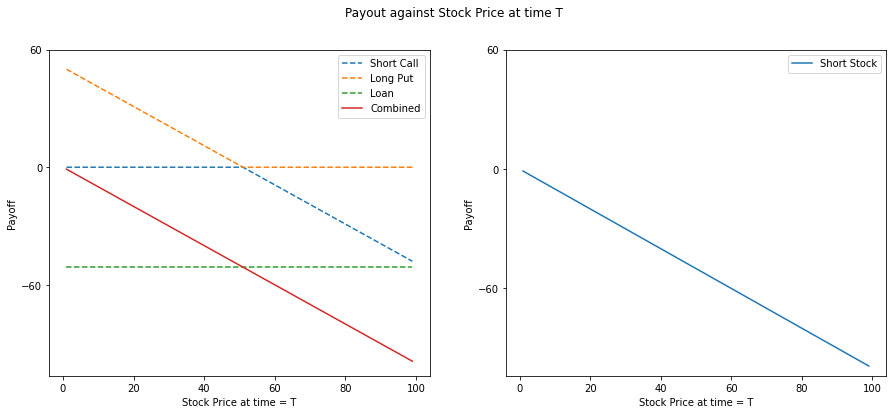

In [5]:
# 4a 

tr4 = np.arange(1,100,1)

def plot4a(st_range):
    sc = [min(51-i,0) for i in st_range]
    lp = [max(51-i,0) for i in st_range]
    loan = [-51 for i in st_range]
    comb = [sc[j]+lp[j]+loan[j] for j in range(len(st_range))]
    synth_s = [-i for i in st_range]

    plots_lst, lbls = [sc,lp,loan,comb], ['Short Call', 'Long Put', 'Loan', 'Combined']
    fig, (ax4_1,ax4_2) = plt.subplots(1,2, figsize = (15,6))
    fig.suptitle("Payout against Stock Price at time T")

    for i in range(len(plots_lst)):
        if i == 3: 
            ax4_1.plot(st_range,plots_lst[i], label = lbls[i])
        else:
            ax4_1.plot(st_range, plots_lst[i], '--', label= lbls[i])

    ax4_2.plot(st_range, synth_s, label = 'Short Stock')


    ax4_1.set_ylabel('Payoff')
    ax4_1.set_xlabel('Stock Price at time = T')
    ax4_1.set_yticks([-60,0,60])
    ax4_1.legend()

    ax4_2.set_ylabel('Payoff')
    ax4_2.set_xlabel('Stock Price at time = T')
    ax4_2.set_yticks([-60,0,60])
    ax4_2.legend()

    plt.title('')
    plt.savefig('Q4(tats) Synthetic Short.jpg')
    plt.show()

plot4a(tr4)

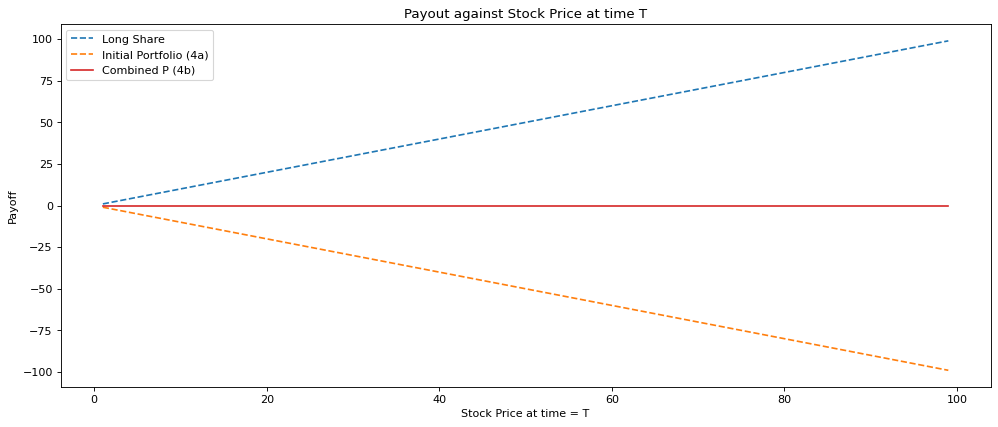

In [6]:
# 4b
def plot4b(st_range):
    sc = [min(51-i,0) for i in st_range]
    lp = [max(51-i,0) for i in st_range]
    loan = [-51 for i in st_range]
    ls = [i for i in st_range]
    comb1 = [sc[j]+lp[j]+loan[j] for j in range(len(st_range))]
    comb2 = [sc[j]+lp[j]+loan[j]+ls[j] for j in range(len(st_range))]

    plots_lst2, lbls = [sc,lp,loan,ls,comb1, comb2], ['Short Call', 'Long Put', 'Loan','Long Share', 'Initial Portfolio (4a)','Combined P (4b)']
    plt.figure(figsize=(15, 6), dpi=80)

    for i in range(len(plots_lst2)):
        if i==5:
            plt.plot(st_range, plots_lst2[i], label= lbls[i], color = 'tab:red')
        elif i == 3 or i == 4:
            plt.plot(st_range, plots_lst2[i], '--', label= lbls[i])

    plt.legend()
    plt.ylabel('Payoff')
    plt.xlabel('Stock Price at time = T')
    plt.title('Payout against Stock Price at time T')
    plt.savefig('Q4(tats) Combined Portfolio 0.jpg')
    plt.show()

plot4b(tr4)

In [7]:
# 5 Today's Volatility
def volatility_n(model, params, last_2_price, last_vol):

    #   model => ewma or garch 
    #   params => for ewma: lambda & for garch: list(gamma, alpha, beta)
    #   last_2_price => list(price n-2, price n-1)
    #   last_vol => Volatility for n-1 => IN PERCENT

    last_return, titles= last_2_price[0] / last_2_price[1] - 1 ,  ['EWMA', 'GARCH(1,1)']
    last_vol = last_vol/100

    if model.lower() == 'ewma':
        lamb, title = params, titles[0]
        out = np.sqrt(lamb*(last_vol**2) + (1-lamb)*(last_return**2))

    elif model.lower() == 'garch':
        omg, alpha, beta, title = params[0], params[1], params[2], titles[1]
        out = np.sqrt(omg + alpha*(last_return**2) + beta*(last_vol**2))
        lt_vol = np.sqrt(omg/(1-alpha-beta))

    print("Today's volatility under " + str(title) + " is: " + str(round(out*100,3)) +"%")
    
    if model.lower() == 'garch':
        print("Long-term volatility for "  + str(title) + " is: " + str(round(lt_vol*100,3)) +"%")        

# EWMA Model 
volatility_n('ewma', 0.94, [300, 298], 1.3)

print('-------------------')

# GARCH (1,1) Model
volatility_n('garch', [0.000002, 0.04, 0.94], [300, 298], 1.3)

Today's volatility under EWMA is: 1.271%
-------------------
Today's volatility under GARCH(1,1) is: 1.275%
Long-term volatility for GARCH(1,1) is: 1.0%


In [8]:
# Decision Tree for Lending Club (Sklearn decision tree) 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Load data
train = pd.read_csv('lendingclub_traindata.csv')
validation=pd.read_csv('lendingclub_valdata.csv')
test = pd.read_csv('lendingclub_testdata.csv')

# Give column names
cols = ['home_ownership', 'income', 'dti', 'fico', 'loan_status']

train.columns = validation.columns=test.columns = cols

# remove target column to create feature only dataset
X_train = train.drop('loan_status', 1)
X_val = validation.drop('loan_status', 1)
X_test = test.drop('loan_status', 1)

# store target column as y-variables 
y_train = train['loan_status']
y_val = validation['loan_status']
y_test = test['loan_status']

C:\Users\tat97\AppData\Local\Temp\ipykernel_15080\1519110583.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = train.drop('loan_status', 1)
C:\Users\tat97\AppData\Local\Temp\ipykernel_15080\1519110583.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_val = validation.drop('loan_status', 1)
C:\Users\tat97\AppData\Local\Temp\ipykernel_15080\1519110583.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = test.drop('loan_status', 1)


In [9]:
# Create function to return new tree with desired metrics
def adjust_decision_tree(depth, split_samples):
    clf = DecisionTreeClassifier(criterion='entropy',
                                max_depth=depth, # Original = 4
                                min_samples_split=split_samples, # Original 1000
                                min_samples_leaf=200,
                                random_state=0)
    return clf.fit(X_train,y_train)

# Test Metrics (5 Levels each) - Tats test metrics
# depth_range = np.arange(1, 10, 2) 
# split_range = np.arange(1000,1, -200) 

# Test Metrics (5 Levels each) - Megans test metrics
# depth_range = np.arange(1, 100, 20) 
# split_range = np.arange(5000,1, -1000) 

# Test Metrics (5 Levels each) - Cambries test metrics
# depth_range = np.arange(2, 21, 1) 
# split_range = np.arange(2000,500, -100) 

# Test Metrics (5 Levels each) - Ideal test metrics
depth_range = np.arange(1, 10, 1) 
split_range = np.arange(1000,1, -50) 

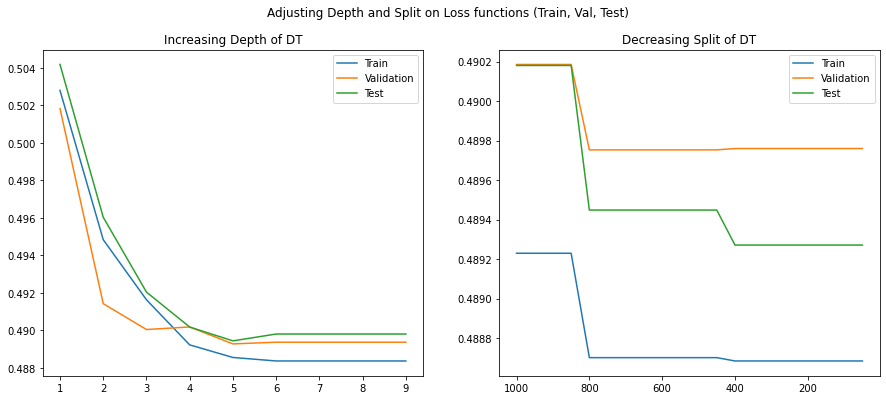

In [10]:
# Effect on loss function (Plot 3 side by side)

def loss_evaluation(dt_model):

    y_train_pred=dt_model.predict_proba(X_train)
    y_val_pred=dt_model.predict_proba(X_val)
    y_test_pred=dt_model.predict_proba(X_test)

    # Calculate maximum likelihood for training set, validation set, and test set

    mle_vector_train = np.log(np.where(y_train == 1, y_train_pred[:,1], y_train_pred[:,0]))
    mle_vector_val = np.log(np.where(y_val == 1, y_val_pred[:,1], y_val_pred[:,0]))
    mle_vector_test = np.log(np.where(y_test == 1, y_test_pred[:,1], y_test_pred[:,0]))

    # Calculate loss functions from maximum likelihoods

    loss_function_training = np.negative(np.sum(mle_vector_train)/len(y_train))
    loss_function_val = np.negative(np.sum(mle_vector_val)/len(y_val))
    loss_function_test = np.negative(np.sum(mle_vector_test)/len(y_test))
    
    return loss_function_training, loss_function_val, loss_function_test

def plot1():
    # Adjusting depth on loss function
    depth_losses = [loss_evaluation(adjust_decision_tree(i, 1000)) for i in depth_range]
    dl_lst = dl_train, dl_val, dl_test = [i[0] for i in depth_losses], [i[1] for i in depth_losses], [i[2] for i in depth_losses]

    # Adjusting split on loss function 
    split_losses = [loss_evaluation(adjust_decision_tree(4, i)) for i in split_range]
    sl_lst = sl_train, sl_val, sl_test =  [i[0] for i in split_losses], [i[1] for i in split_losses], [i[2] for i in split_losses]

    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,6))
    fig.suptitle("Adjusting Depth and Split on Loss functions (Train, Val, Test)")
    labels = ['Train', 'Validation', 'Test']
    
    for i in range(len(dl_lst)):
        ax1.plot(depth_range, dl_lst[i], label = labels[i])
    for i in range(len(sl_lst)):
        ax2.plot(split_range, sl_lst[i], label = labels[i])

    ax1.legend()
    ax2.legend()
    ax2.invert_xaxis()
    ax1.set_title('Increasing Depth of DT')
    ax2.set_title('Decreasing Split of DT')
    plt.savefig('Q7(tats) Changing D&S on Loss.jpg')
    plt.show()

plot1()

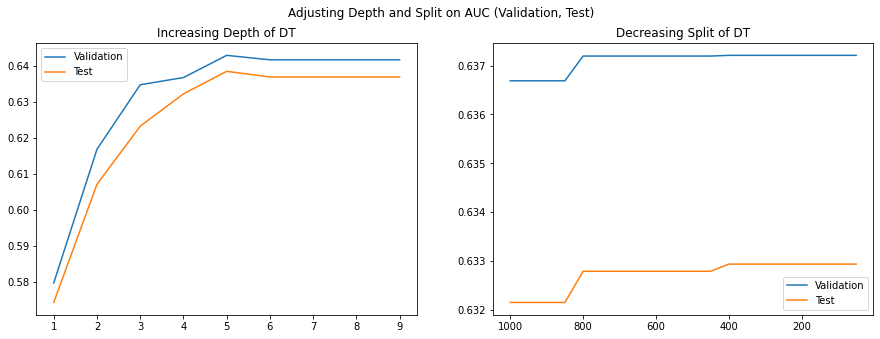

In [11]:
# Effect on AUC ROC
def get_data (evaluate_on):
    if evaluate_on == 'test':
        X,y = X_test, y_test
    elif evaluate_on == 'validate':
        X,y = X_val, y_val
    else:
        print('Error: evaluate_on must be either "test" or "validate"')
        X, y = (None, None)
    return X,y

def get_cm (z, dt_model, evaluate_on ):
    # Get the appropriate feature and outcome data    
    X,y = get_data (evaluate_on)
    # If prob for data set > threshold predict 1
    preds = np.where(dt_model.predict_proba(X)[:,1] > z, 1, 0)                                      
    # create confusion matrix 
    cm = confusion_matrix(y, preds,labels=[1, 0], sample_weight=None) # confusion matrix 
    return cm

def get_ratios (cm):
    TP = cm[0][0] # True Positives                                                                                          
    FN = cm[0][1] # False Negatives                                                                                         
    FP = cm[1][0] # False Positives                                                                                        
    TN = cm[1][1] # True Negatives                                                                                          
    TPR = TP/(TP+FN) # True Positive Rate (sensitivity/recall)                                                                                       
    FNR = FN/(TP+FN) # False Negative Rate (miss rate)                                                                                      
    TNR = TN/(TN+FP) # True Negative Rate (specificity)                                                                                      
    FPR = FP/(TN+FP) # False Positive Rate (fall-out) 
    Accuracy = (TP+TN)/(TP+FN+FP+TN)
    return Accuracy, TPR, FNR, TNR, FPR

# Calculate the receiver operating curve and the AUC measure
def ROC_curve (dt_model, evaluate_on):
    # Get the appropriate feature and outcome data    
    X,y = get_data (evaluate_on)
    # Get the predicted probablities from the current model and from random predictions
    model_prob = dt_model.predict_proba(X)
    model_prob = model_prob[:, 1]
    ns_prob=[0 for _ in range(len(y))]
    # Get the AUC scores
    ns_auc=roc_auc_score(y, ns_prob)
    model_auc = roc_auc_score(y,model_prob)
    # Calculate the ROC curve of the current model and that of random guess
    ns_fpr,ns_tpr,_=roc_curve(y,ns_prob)
    model_fpr,model_tpr,_=roc_curve(y,model_prob)
    return model_auc

def plot2():
    # Adjusting depth on model auc
    d_auc_lst = [ROC_curve(adjust_decision_tree(i, 1000), 'validate') for i in depth_range], [ROC_curve(adjust_decision_tree(i, 1000), 'test') for i in depth_range]

    # Adjusting split on model auc
    s_auc_lst = [ROC_curve(adjust_decision_tree(4,i), 'validate') for i in split_range], [ROC_curve(adjust_decision_tree(4,i), 'test') for i in split_range]

    # Plotting Curves
    fig2, (ax3,ax4) = plt.subplots(1,2, figsize = (15,5))
    fig2.suptitle("Adjusting Depth and Split on AUC (Validation, Test)")

    labels_auc = ['Validation', 'Test']

    for i in range(len(d_auc_lst)):
        ax3.plot(depth_range, d_auc_lst[i], label = labels_auc[i])
    for i in range(len(s_auc_lst)):
        ax4.plot(split_range, s_auc_lst[i], label = labels_auc[i])
        
    ax3.legend()
    ax4.legend()
    ax3.set_title('Increasing Depth of DT')
    ax4.set_title('Decreasing Split of DT')
    ax4.invert_xaxis()
    plt.savefig('Q7(tats) Changing D&S on AUC.jpg')
    plt.show()

plot2()

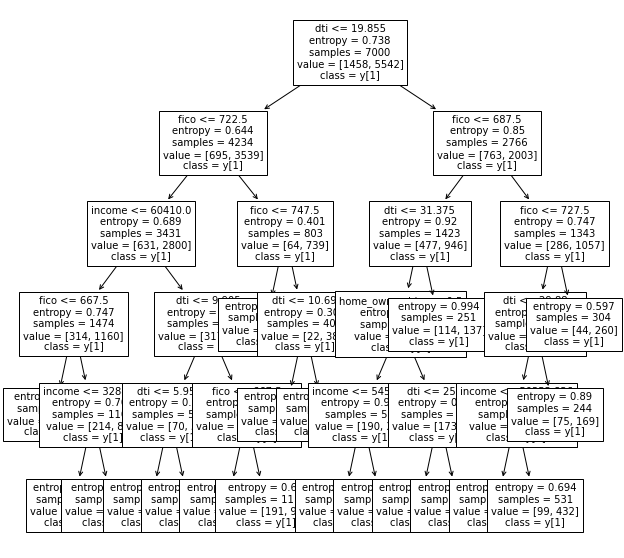

In [12]:
# From our results optimal depth = 5, optimal split = 400

# Fit new tree 
ideal_clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=5,
                             min_samples_split=400,
                             min_samples_leaf=200,
                             random_state=0)
ideal_clf.fit(X_train,y_train)

fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(ideal_clf, fontsize=10, feature_names=X_train.columns.values, class_names = True)
plt.savefig('Q7(tats) Ideal Tree.jpg')
plt.show()

In [13]:
# Loss functions
loss_function_training, loss_function_val, loss_function_test = loss_evaluation(ideal_clf)
print('Average loss function for training set =', loss_function_training)
print('Average loss function for validation set =', loss_function_val)
print('Average loss function for test set =', loss_function_test)

Average loss function for training set = 0.4869145790337435
Average loss function for validation set = 0.4879937297700203
Average loss function for test set = 0.48971687049593826


AUC random predictions = 0.5
AUC predictions from the current classifier = 0.636795632752506


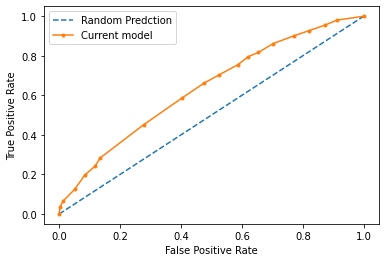

0.636795632752506

In [14]:
def ROC_curve_with_plot (reg_model, evaluate_on = 'test'):
    
    ###########
    # Plot the ROC curve of a given classifier and the data to evaluate on. Also, calculate the AUC measure.
    # Input: reg_model is a sklearn classifier 
    #        evaluate_on is either 'test' or 'validate', meaning whether the confusion matrix is evaluated on the
    #        validation data or test data. By default, the ROC curve is evaluated on the test data.
    # Output: The AUC measure. Also, plot the curve.
    ###########
    
    # Get the appropriate feature and outcome data    
    X,y = get_data (evaluate_on)
    
    # Get the predicted probablities from the current model and from random predictions
    model_prob = reg_model.predict_proba(X)
    model_prob = model_prob[:, 1]
    ns_prob=[0 for _ in range(len(y))]
    
    # Get the AUC scores
    ns_auc=roc_auc_score(y, ns_prob)
    model_auc = roc_auc_score(y,model_prob)
    
    # Calculate the ROC curve of the current model and that of random guess
    print("AUC random predictions =", ns_auc)
    print("AUC predictions from the current classifier =", model_auc)
    ns_fpr,ns_tpr,_=roc_curve(y,ns_prob)
    model_fpr,model_tpr,_=roc_curve(y,model_prob)

    # Plot the ROC curve and compare it with that of random guess
    plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Predction')
    plt.plot(model_fpr,model_tpr, marker='.',label='Current model')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig('Q7(tats) Ideal ROC.jpg')
    plt.show()
    
    return model_auc

ROC_curve_with_plot(ideal_clf)

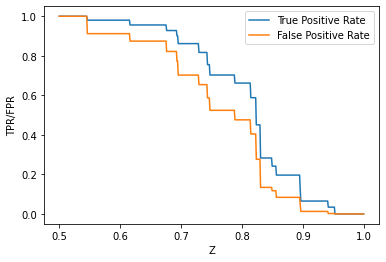

In [15]:
P = 0.1 # The expected profit from accepting a good loan
L = 1 # The expected loss from accepting a bad loan

# Grid search for the threshold 
zrange_default = np.arange(0.5,1,0.001) 

def TPR_FPR_curve (reg_model, evaluate_on, zrange = zrange_default):
    
    ###########
    # Evaluate and plot the TPR/FPR curve 
    # Input: reg_model is the classifier of interest
    #        evaluate_on is either 'test' or 'validate', meaning whether the evaluation is based on validation or test data
    #        zrange is the range that the treshold Z takes value in
    # Output: The (realized) expected payff from an average borrower
    ###########

    
    # We calculate how TPR and FPR depend on the range of z
    cms = [get_cm(z, reg_model, evaluate_on = evaluate_on) for z in zrange] #Creat a list of confusion matrices, each for a difference z
    ratios = np.array([get_ratios (cm) for cm in cms ]) # For every confusion matrix in the list, calculate the corresponding ratios
    TPR_lr = ratios[:,1]
    FPR_lr = ratios[:,4]
    
    
    # Next, we plot the TPR/FPR curves
    plt.plot( zrange , TPR_lr,label='True Positive Rate')
    plt.plot( zrange , FPR_lr,label='False Positive Rate')

    plt.xlabel('Z')
    plt.ylabel('TPR/FPR')
    plt.legend()
    plt.savefig('Q7(tats) Ideal TPR_FPR_curve.jpg',bbox_inches='tight', transparent=True)
    plt.show()

# Illustrate the performance on test data    
TPR_FPR_curve(ideal_clf, 'test')

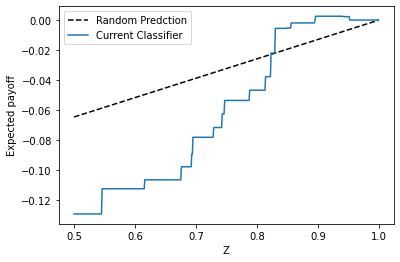

The optimal Z is:  0.8960000000000004
The maximual expected payoff using the current predictor is:  0.0025327510917030577
The confusion matrix under the optimal Z is: 
[[ 118 1695]
 [   6  471]]
The relavant ratios under the optimal Z are: 
Accuracy rate: 0.2572052401746725  TPR: 0.06508549365692223  FPR: 0.012578616352201259


In [16]:
def get_EP (z, dt_model, evaluate_on):
    # Get the appropriate feature and outcome data    
    X,y = get_data (evaluate_on)
    cm = get_cm (z, dt_model, evaluate_on)
    Accuracy, TPR, FNR, TNR, FPR = get_ratios (cm)

    frac_p = np.sum(y)/len(y) #the fraction of positive outcomes (i.e., good loans) in the validation dataset
    frac_n = np.sum(1-y)/len(y) #total number of negative outcomes (i.e., bad loans) in the validation dataset
    
    # The expected value is P * "Good loan"% * TPR - L * "Bad Loan"% * FPR
    EP = P * frac_p * TPR - L * frac_n * FPR 
    return EP

def EP_curve_with_plot (reg_model, evaluate_on, zrange = zrange_default):
    
    ###########    
    # Evaluate and plot the (realized) expected payoff curve. Also, we obtain the threshold based on the curve.
    # Input: reg_model is the classifier of interest
    #        evaluate_on is either 'test' or 'validate', 
    #        meaning whether the evaluation is based on validation or test data
    #        zrange is the range that the treshold Z takes value in
    # Output: The (realized) expected payff from an average borrower
    ###########


    # We calculate the expected payoff as a function of Z
    EP_lr = np.array([get_EP(z, reg_model, evaluate_on = evaluate_on)  for z in zrange]) #The expected payoff curve for the current predictor
    EP_rg = EP_lr[0] + zrange * (EP_lr[-1] - EP_lr[0]) #The expected payoff curve for the random guess predictor

    plt.plot( zrange, EP_rg,linestyle='--',color = 'black', label='Random Predction')
    plt.plot( zrange , EP_lr,label='Current Classifier')

    plt.xlabel('Z')
    plt.ylabel('Expected payoff')
    plt.legend()
    plt.savefig('Q7(tats) EP_curve.jpg',bbox_inches='tight', transparent=True)
    plt.show()

    # Analysis of the optimal threshold

    z_optimal = zrange [np.argmax(EP_lr)]
    
    '''# The largest optimal solution (because of ties) 
    # Uncomment if needed
    z_optimal = zrange [len(EP_lr) - np.argmax(EP_lr[::-1]) - 1]'''

    print('The optimal Z is: ', z_optimal)
    print('The maximual expected payoff using the current predictor is: ', np.max (EP_lr) )
    print('The confusion matrix under the optimal Z is: ')

    print(get_cm(z_optimal, reg_model, evaluate_on = evaluate_on))
    Accuracy, TPR, FNR, TNR, FPR = get_ratios (get_cm(z_optimal, reg_model, evaluate_on = evaluate_on))
    print('The relavant ratios under the optimal Z are: ')
    print('Accuracy rate:', Accuracy, ' TPR:', TPR, ' FPR:',  FPR)

EP_curve_with_plot(ideal_clf, 'test')

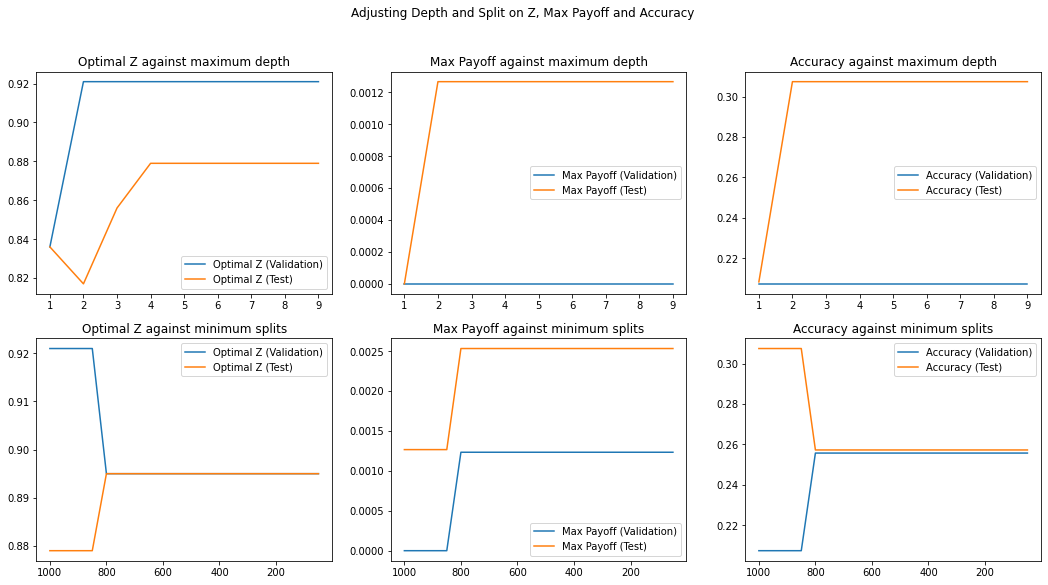

In [17]:
# Additional findings, not in report

def EP_metrics(dt_model, evaluate_on, zrange = zrange_default):
    # We calculate the expected payoff as a function of Z
    EP_dt = np.array([get_EP(z, dt_model, evaluate_on = evaluate_on)  for z in zrange]) #The expected payoff curve for the current predictor

    # Analysis of the optimal threshold
    z_optimal = zrange [np.argmax(EP_dt)]
    max_payoff = np.max (EP_dt)
    Accuracy, TPR, FNR, TNR, FPR = get_ratios (get_cm(z_optimal, dt_model, evaluate_on = evaluate_on))

    return z_optimal, max_payoff, Accuracy

def plot_summary():
    ## For validation
    # Adjusting depth on ep metrics
    d_mets_val = [EP_metrics(adjust_decision_tree(i, 1000), 'validate') for i in depth_range]
    d_mets_lst = [[i[0] for i in d_mets_val], [i[1] for i in d_mets_val], [i[2] for i in d_mets_val]]

    # Adjusting split on ep metrics
    s_mets_val = [EP_metrics(adjust_decision_tree(4, i), 'validate') for i in split_range]
    s_mets_lst = [[i[0] for i in s_mets_val], [i[1] for i in s_mets_val], [i[2] for i in s_mets_val]]

    ## For test 
    # Adjusting depth on ep metrics
    d_mets_test = [EP_metrics(adjust_decision_tree(i, 1000), 'test') for i in depth_range]
    d_mets_tlst = [[i[0] for i in d_mets_test], [i[1] for i in d_mets_test], [i[2] for i in d_mets_test]]

    # Adjusting split on ep metrics
    s_mets_test = [EP_metrics(adjust_decision_tree(4, i), 'test') for i in split_range]
    s_mets_tlst = [[i[0] for i in s_mets_test], [i[1] for i in s_mets_test], [i[2] for i in s_mets_test]]
    
    ## Assign metrics aka Y axis
    # Index 0: validation, Index 1: test
    z_optimal_depth = d_mets_lst[0], d_mets_tlst[0]
    max_pay_depth  = d_mets_lst[1], d_mets_tlst[1]
    accuracy_depth  = d_mets_lst[2], d_mets_tlst[2]

    z_optimal_split = s_mets_lst[0], s_mets_tlst[0]
    max_pay_split  = s_mets_lst[1], s_mets_tlst[1]
    accuracy_split  = s_mets_lst[2], s_mets_tlst[2]

    depth_change_list, split_change_list = [z_optimal_depth,max_pay_depth, accuracy_depth], [z_optimal_split,max_pay_split,accuracy_split]

    ## Create plots
    fig3, ((ax1,ax2,ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (18,9))
    fig3.suptitle("Adjusting Depth and Split on Z, Max Payoff and Accuracy")
    d_plots, s_plots = [ax1,ax2,ax3], [ax4,ax5,ax6]
    labels = ['Optimal Z', 'Max Payoff', 'Accuracy']

    for i in range(3):
        
        d_plots[i].plot(depth_range, depth_change_list[i][0], label = str(labels[i]) + ' (Validation)')
        d_plots[i].plot(depth_range, depth_change_list[i][1], label = str(labels[i]) + ' (Test)')
        s_plots[i].plot(split_range, split_change_list[i][0], label = str(labels[i]) + ' (Validation)')
        s_plots[i].plot(split_range, split_change_list[i][1], label = str(labels[i]) + ' (Test)')
    
    for ind in range(len(d_plots)):
        d_plots[ind].set_title(str(labels[ind]) + ' against maximum depth')
        s_plots[ind].set_title(str(labels[ind]) + ' against minimum splits')
        d_plots[ind].legend()
        s_plots[ind].legend()

    for plot in s_plots:
        plot.invert_xaxis()
    plt.savefig('Q7(tats) Changing D&S on Z,MP,Acc.jpg')
    plt.show()

plot_summary()